In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import cv2

from pipeline import process_images
from feature_extractors import raw_pixels, hog_features, pca_features, statistical_features
from clustering import cluster_dbscan, cluster_kmeans

from utils import show_mirror, add_box_around_mirror, add_box_around_mirror_with_color

In [ ]:
%reload_ext autoreload

In [ ]:
! pwd

In [ ]:
! ls ../..

In [ ]:
! pwd

## Set path to H5 file

In [4]:
PATH_GPU = "/home/pgliwny/computer_vision_project/data"
PATH_ADATA = "/media/pgliwny/ADATA HD330/Computer_vision_for_MAGIC/prepare_images/data"
H5_PATH = os.path.join(PATH_ADATA, "webcam_images.h5")

# Read mirror

In [ ]:
PATH_GPU = "/home/pgliwny/computer_vision_project/data"
H5_PATH = os.path.join(PATH_GPU, "webcam_images.h5")
MIRRORS = ["mirror_183"]  # etc.

# Run test
for mirror in MIRRORS:
    print(f"\nProcessing {mirror}...")
    labels, feats = process_images(
        h5file=H5_PATH,
        extractor_fn=raw_pixels,
        cluster_fn=lambda X: cluster_dbscan(X, eps=2.5, min_samples=2),
        mirror_id=mirror
    )
    print(f"Unique clusters: {set(labels)}")

In [ ]:
# 3. Reduce to 2D for plotting
pca = PCA(n_components=2)
proj = pca.fit_transform(feats)

# 2. Plot with legend
plt.figure(figsize=(6, 5))
unique_labels = np.unique(labels)

for label in unique_labels:
    idx = labels == label
    label_name = f"Cluster {label}" if label != -1 else "Outlier"
    plt.scatter(proj[idx, 0], proj[idx, 1], label=label_name)

plt.title("Mirror Images: PCA on grey image of mirror, colored by DBSCAN")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
MIRRORS_LIST = [f"mirror_{i}" for i in range(1, 289)]

labels_by_mirror = {}
# Run test
for mirror in MIRRORS_LIST:
    #print(f"\nProcessing {mirror}...")
    labels, feats = process_images(
        h5file=H5_PATH,
        extractor_fn=raw_pixels,
        cluster_fn=lambda X: cluster_dbscan(X, eps=2.5, min_samples=2),
        mirror_id=mirror
    )
    labels_by_mirror[mirror] = labels
    #print(f"Unique clusters: {set(labels)}")

In [ ]:
labels_by_mirror["mirror_25"]

In [ ]:
MIRRORS_LIST = [f"mirror_{i}" for i in range(1, 289)]

H5_PATH = "/home/pgliwny/computer_vision_project/data/webcam_images.h5"

event_id = 142
list_of_mirrors = []
# Run test
for mirror in MIRRORS_LIST:
    if labels_by_mirror[mirror][event_id] == -1:
        list_of_mirrors.append(int(mirror.split("_")[-1]))

f = h5py.File("/home/pgliwny/computer_vision_project/data/webcam_images.h5", "r")
keys = list(f["images"].keys())
add_box_around_mirror(f["images"][keys[event_id]]["image"][:], list_of_mirrors)
f.close()

In [ ]:
! ls /home/pgliwny/computer_vision_project/data

In [ ]:
f = h5py.File("/home/pgliwny/computer_vision_project/data/webcam_images.h5", "r")
keys = list(f["images"].keys())
add_box_around_mirror(f["images"][keys[event_id]]["image"][:], list_of_mirrors)
f.close()

In [ ]:
add_box_around_mirror(f["images"][keys[event_id]]["image"][:], list_of_mirrors)

In [ ]:
list_of_mirrors = []
event_id = 130
for key in labels_by_mirror.keys():
    label = labels_by_mirror[key][event_id]
    if label == -1:
        #print(key, label)
        list_of_mirrors.append(int(key.split("_")[-1]))
        
add_box_around_mirror(f["images"][keys[event_id]]["image"][:], list_of_mirrors)

# Cluster mirrors from one event

In [5]:
f = h5py.File(H5_PATH, "r")
keys = list(f["images"].keys())

In [6]:
keys[:5]

['entry_0', 'entry_1', 'entry_10', 'entry_100', 'entry_101']

In [8]:
img_mirror = f["images"]["entry_10"]["mirrors"]["mirror_10"][:]

In [9]:
img_mirror.shape

(21, 20)

In [10]:
target_shape = (16, 18)
resized = cv2.resize(img_mirror, target_shape, interpolation=cv2.INTER_AREA)
flattened = resized.flatten() / 255.0

In [11]:
entry_id = "entry_10"
target_shape = (16, 18)

with h5py.File(H5_PATH, "r") as f:
    mirror_group = f["images"][entry_id]["mirrors"]
    mirror_names = list(mirror_group.keys())
    
    images = []
    mirror_ids = []
    for name in mirror_names:
        img = mirror_group[name][:]
        resized = cv2.resize(img, target_shape, interpolation=cv2.INTER_AREA)
        flattened = resized.flatten() / 255.0
        images.append(flattened)
        mirror_ids.append(name)
    X = np.stack(images)

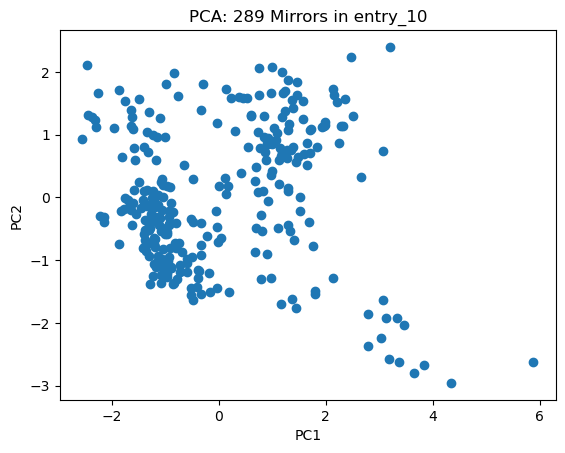

In [12]:
pca = PCA(n_components=2)
X_proj = pca.fit_transform(X)

plt.scatter(X_proj[:, 0], X_proj[:, 1])
plt.title("PCA: 289 Mirrors in entry_10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

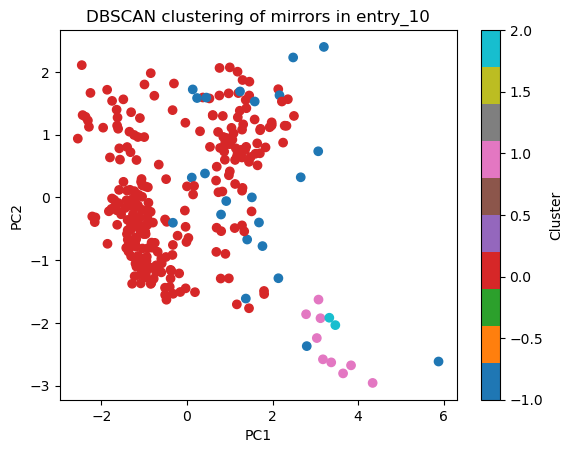

In [13]:
# Start with something simple
db = DBSCAN(eps=2.5, min_samples=2).fit(X)
labels = db.labels_  # array of cluster assignments

# Visualize
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=labels, cmap='tab10')
plt.title("DBSCAN clustering of mirrors in entry_10")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

In [14]:
set(labels)

{np.int64(-1), np.int64(0), np.int64(1), np.int64(2)}

In [15]:
np.where(labels == -1)

(array([  0,   1,  25,  32,  72,  89,  91,  94, 145, 164, 167, 183, 184,
        187, 202, 203, 204, 205, 216, 236, 237, 242, 261]),)

In [ ]:
labels.shape

In [ ]:
f = h5py.File(H5_PATH, "r")
add_box_around_mirror(f["images"][entry_id]["image"][:], [20, 30])
f.close()

In [ ]:
f = h5py.File(H5_PATH, "r")
add_box_around_mirror_with_color(f["images"][entry_id]["image"][:], [20, 30], "red")
f.close()

In [17]:
f = h5py.File(H5_PATH, "r")

In [18]:
f.keys()

<KeysViewHDF5 ['images']>

In [19]:
f["images"]["entry_0"].keys()

<KeysViewHDF5 ['image', 'image_name', 'mirrors']>

In [27]:
labels_dict = {
    "clus -1":[], 
    "clus 0": [],
    "clus 1": [],
    "clus 2": []
}

In [28]:
for mirror_id, label in zip(f["images"][entry_id]["mirrors"].keys(), labels):
    if label == -1:
        m_id = int(mirror_id.split("_")[1])
        labels_dict["clus -1"].append(m_id)
    if label == 0:
        m_id = int(mirror_id.split("_")[1])
        labels_dict["clus 0"].append(m_id)
    if label == 1:
        m_id = int(mirror_id.split("_")[1])
        labels_dict["clus 1"].append(m_id)
    if label == 2:
        m_id = int(mirror_id.split("_")[1])
        labels_dict["clus 2"].append(m_id)

In [30]:
labels_dict["clus 1"]

[13, 14, 15, 16, 31, 32, 49, 50, 67]

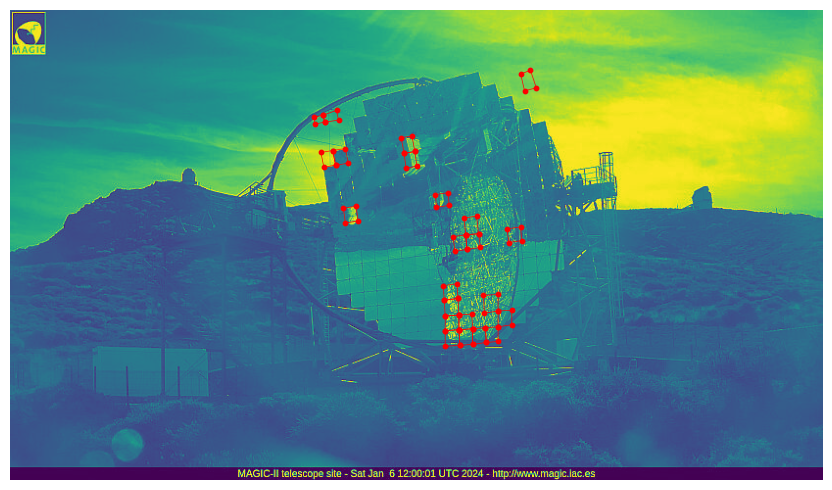

In [31]:
f = h5py.File(H5_PATH, "r")
add_box_around_mirror_with_color(f["images"][entry_id]["image"][:], labels_dict["clus -1"], "red")
f.close()

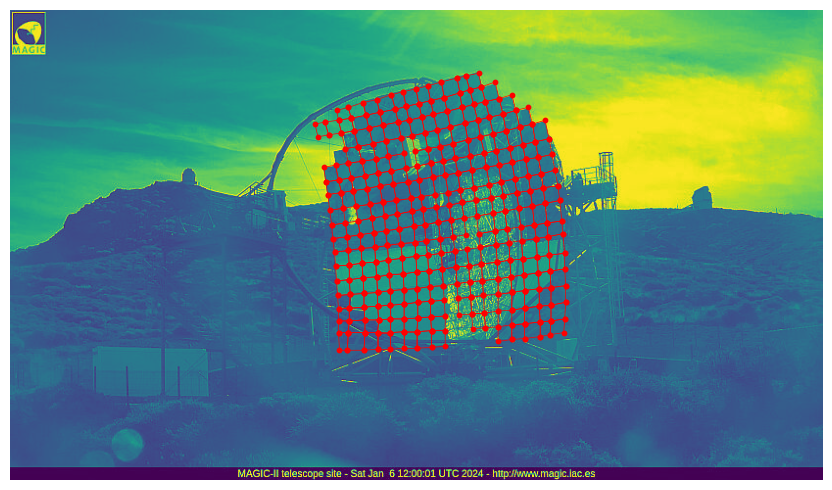

In [32]:
f = h5py.File(H5_PATH, "r")
add_box_around_mirror_with_color(f["images"][entry_id]["image"][:], labels_dict["clus 0"], "red")
f.close()

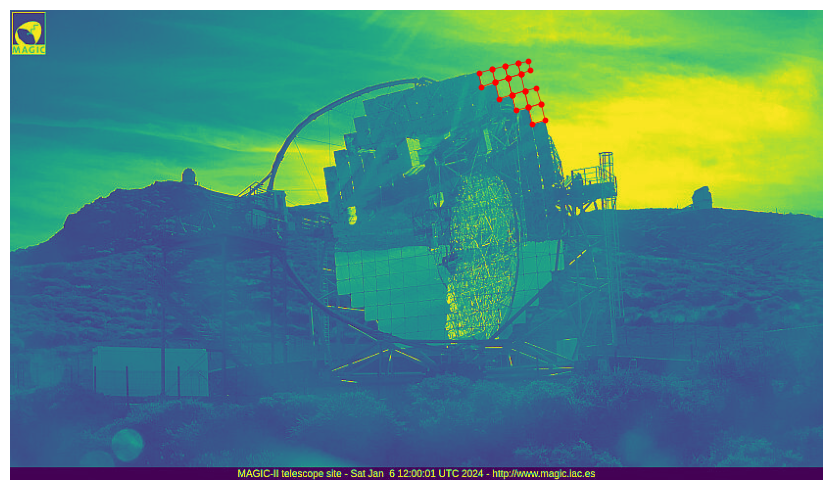

In [33]:
f = h5py.File(H5_PATH, "r")
add_box_around_mirror_with_color(f["images"][entry_id]["image"][:], labels_dict["clus 1"], "red")
f.close()

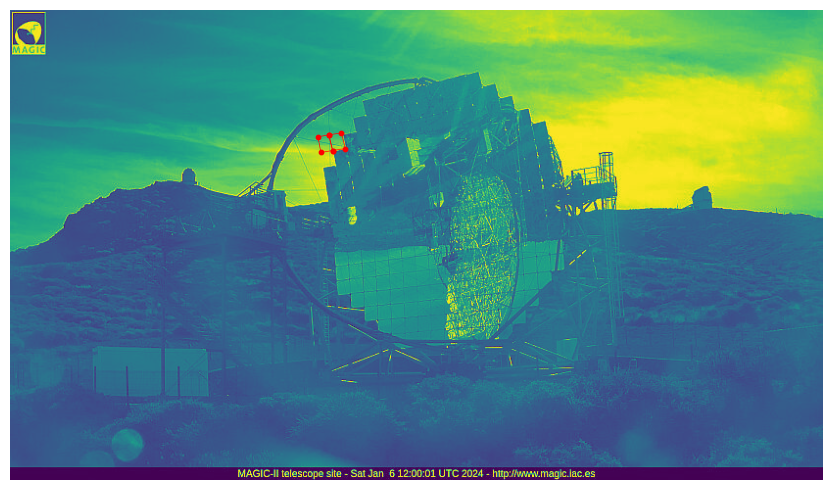

In [34]:
f = h5py.File(H5_PATH, "r")
add_box_around_mirror_with_color(f["images"][entry_id]["image"][:], labels_dict["clus 2"], "red")
f.close()

In [35]:
f = h5py.File(H5_PATH, "r")

In [37]:
f["images"][entry_id]["mirrors"]

<HDF5 group "/images/entry_10/mirrors" (289 members)>